In [24]:
!pip install jax diffrax --quiet

import jax
import jax.numpy as jnp
from jax import grad, jit, random
import diffrax
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm


H shape (complex): (6, 6) -> realified shape: (12, 12)
x_true (complex) shape: (6,) -> realified shape: (12,)
y shape: (12,)
J shape: (12, 12) b shape: (12,)
||J|| = 0.42268494 ||b|| = 88.245445
Converged at step 667, t=6.680058002471924
Converged solution (phi): [4.7124095 1.5707964 1.5708001 4.71239   1.5707976 7.8539834 1.5707961
 1.5707959 1.5707959 1.5707961 1.5707961 1.5707961]
Returned solution length: 668 steps
Final time: 6.680058002471924
Final solution shape: (668, 12)


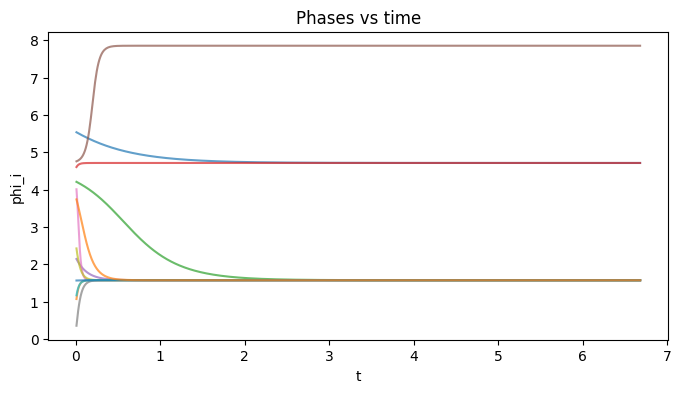

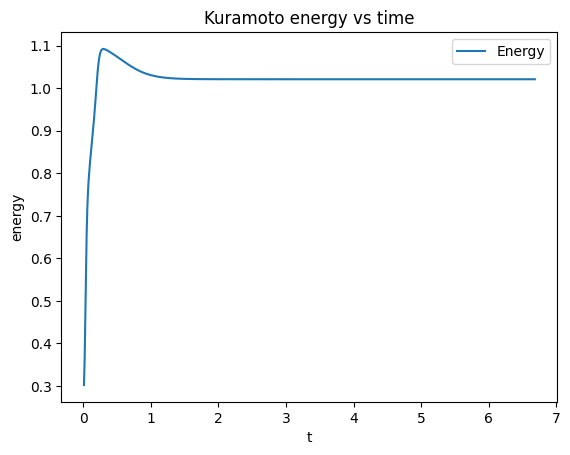

phi_final: [4.7124095 1.5707964 1.5708001 4.71239   1.5707976 7.8539834 1.5707961
 1.5707959 1.5707959 1.5707961 1.5707961 1.5707961]
phi_q: [4.712389  1.5707964 1.5707964 4.712389  1.5707964 1.5707964 1.5707964
 1.5707964 1.5707964 1.5707964 1.5707964 1.5707964]


In [39]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import diffrax
import numpy as np
import matplotlib.pyplot as plt

def make_mimo_problem(M=3, N=3, seed=42):
    """
    Returns a random complex MIMO matrix H, a random transmitted x (4-QAM),
    and the received y = H x + noise.
    We also provide the realified H, y, i.e. dimension is now 2M x 2N.
    """
    key = random.PRNGKey(seed)
    # Random complex channel
    key, subkey = random.split(key)
    H_real = random.normal(subkey, (M, N))
    key, subkey = random.split(key)
    H_imag = random.normal(subkey, (M, N))
    H_C = H_real + 1j * H_imag

    # True transmitted x in {±1 ± j} (4-QAM)
    key, subkey = random.split(key)
    x_C_re = 2*(random.bernoulli(subkey, p=0.5, shape=(N,))) - 1
    key, subkey = random.split(key)
    x_C_im = 2*(random.bernoulli(subkey, p=0.5, shape=(N,))) - 1
    x_C = x_C_re + 1j*x_C_im

    # Noise
    sigma = 0.1
    key, subkey = random.split(key)
    noise = sigma*(random.normal(subkey, (M,)) + 1j*random.normal(subkey, (M,)))

    # Received
    y_C = H_C @ x_C + noise

    # Realify
    H_up = jnp.hstack([H_real, -H_imag])
    H_bot = jnp.hstack([H_imag,  H_real])
    H = jnp.vstack([H_up, H_bot])

    x = jnp.concatenate([jnp.real(x_C), jnp.imag(x_C)])
    y = jnp.concatenate([jnp.real(y_C), jnp.imag(y_C)])
    return H_C, x_C, y_C, H, x, y

# Generate problem
H_C, x_C, y_C, H, x_true, y = make_mimo_problem(M=6, N=6, seed=123)
print("H shape (complex):", H_C.shape, "-> realified shape:", H.shape)
print("x_true (complex) shape:", x_C.shape, "-> realified shape:", x_true.shape)
print("y shape:", y.shape)


@jit
def build_couplings(H, y, scaling=1.0):
    """
    Return J = (H^T H) / ||H||^2,   b = H^T y * scaling
    """
    norm_H_sq = jnp.linalg.norm(H)**2
    J = (H.T @ H) / norm_H_sq
    b = (H.T @ y) * scaling
    return J, b

J, b = build_couplings(H, y, scaling=1.0)
print("J shape:", J.shape, "b shape:", b.shape)
print("||J|| =", jnp.linalg.norm(J), "||b|| =", jnp.linalg.norm(b))

@jit
def kuramoto_ode(t, phi, args):
    J_ = args['J']
    b_ = args['b']
    alpha = args['alpha']

    # Coupling
    coupling = (J_ * jnp.sin(phi[:, None] - phi[None, :])).sum(axis=-1) / phi.size

    # Field
    field = b_ * jnp.cos(phi)

    # Penalty to push toward Q=4
    penalty = -alpha * jnp.sin(4.0 * phi)

    return coupling + field + penalty

@jit
def energy_kuramoto(phi, J_):
    """
    E = 0.5 * sum_{ij} J_ij * cos(phi_i - phi_j).
    """
    return 0.5 * (J_ * jnp.cos(phi[:, None] - phi[None, :])).sum()

@jit
def save_func(t, phi, args):
    energy = energy_kuramoto(phi, args['J'])
    return {'energy': energy, 'phi': phi, 't': t}

def run_kuramoto(J, b, alpha=0.01, max_steps=100_000):
    """
    Runs the Kuramoto ODE with a constant step size.
    Once convergence is detected, it truncates the solution
    and returns the truncated arrays.
    """
    phi_size = J.shape[0]
    key = random.PRNGKey(0)
    phi_init = random.uniform(key, shape=(phi_size,), minval=0, maxval=2*jnp.pi)

    args = {'J': J, 'b': b, 'alpha': alpha}
    term = diffrax.ODETerm(kuramoto_ode)

    stepsize_controller = diffrax.ConstantStepSize()

    sol = diffrax.diffeqsolve(
        term,
        solver=diffrax.Dopri5(),
        t0=0,
        t1=300.0,
        y0=phi_init,
        dt0 = 1e-2,
        args=args,
        max_steps=max_steps,
        saveat=diffrax.SaveAt(steps=True, fn=save_func),
        stepsize_controller=stepsize_controller,
        adjoint=diffrax.RecursiveCheckpointAdjoint(),
    )

    consecutive_stable = 0
    tolerance = 1e-8
    converged_step = None

    for i in range(1, len(sol.ts)):
        diff = jnp.linalg.norm(sol.ys['phi'][i] - sol.ys['phi'][i-1])
        if diff < tolerance:
            consecutive_stable += 1
        else:
            consecutive_stable = 0

        if consecutive_stable > 50:
            converged_step = i
            print(f"Converged at step {i}, t={sol.ts[i]}")
            print("Converged solution (phi):", sol.ys['phi'][i])
            break

    # If converged, truncate the solution arrays so we stop computing.
    if converged_step is not None:
        truncated_ts = sol.ts[:converged_step + 1]
        truncated_ys = {
            key_: val_[:converged_step + 1] for key_, val_ in sol.ys.items()
        }
        return truncated_ts, truncated_ys
    else:
        # If we never converged, return the entire solution
        return sol.ts, sol.ys


#################
# Run the solver
#################

sol_ts, sol_ys = run_kuramoto(J, b, alpha=0.01, max_steps=100_000)

print(f"Returned solution length: {len(sol_ts)} steps")
print(f"Final time: {sol_ts[-1]}")
print(f"Final solution shape: {sol_ys['phi'].shape}")

# Plot phases over time
plt.figure(figsize=(8,4))
plt.title("Phases vs time")
for i in range(sol_ys['phi'].shape[1]):
    plt.plot(sol_ts, sol_ys['phi'][:, i], alpha=0.7)
plt.xlabel("t")
plt.ylabel("phi_i")
plt.show()

# Plot the energy curve
plt.figure()
plt.title("Kuramoto energy vs time")
plt.plot(sol_ts, sol_ys['energy'], label='Energy')
plt.xlabel("t")
plt.ylabel("energy")
plt.legend()
plt.show()

def quantize_phases(phi, Q=4):
    """
    Map each phi_i to the nearest discrete angle of 2*pi/Q * k,
    k = 0,1,2,...,Q-1.
    """
    phi = phi % (2*jnp.pi)
    ref = jnp.linspace(0, 2*jnp.pi, Q, endpoint=False)
    diffs = jnp.abs(phi[:, None] - ref[None, :])
    idx = jnp.argmin(diffs, axis=1)
    return ref[idx]

# Get the last set of phases
phi_final = sol_ys['phi'][-1]
phi_q = quantize_phases(phi_final, Q=4)

print("phi_final:", phi_final)
print("phi_q:", phi_q)